# Using Machine Learning in the EOS problem

# Piecewise Polytropic Fit

When creating neutron star stellar models numerically, it is common to fit a realistic EOS with piecewise polytropes that make the numerical calculations easier. In the following we'll try to set up a routine to fit any EOS using $n$ polytropes. The number $n$ should be obtained by keeping the error of the fit low in each segment.

In a polytropic EOS the pressure is written in terms of the energy density as

$$ P = K \rho^{\gamma}. $$

In order to fit a numerical EOS to a polytropic one, it's possible to linearize the polytrope in the following way

\begin{align*}
\frac{P}{K} &= \rho^{\gamma} \\
\log_\rho\left( \frac{P}{K} \right) &= \gamma \\
\frac{\log_{10}\left( \frac{P}{K} \right) }{\log_{10}(\rho)} &= \gamma \\
\log_{10}(P) &= \gamma \log_{10}(\rho) + \log_{10}(K).
\end{align*}

With the polytropic EOS written in this form, a least squares linear regression model can be trained to find the parameters $\gamma$ and $K$ that better fit the values of a numerical EOS within some range of densities $[\rho_i,\rho_{i+1}]$.

If a fit starts at a density $\rho_i$ with density $P_{i}$, the parameter $K_{i+1}$ of the next polytropic segment is fixed to ensure the continuity of the pressure:

$$ \log_{10}(P_i) = \gamma_{i+1} \log_{10}(\rho_i) + \log_{10}(K_{i+1}) \quad \Rightarrow \quad \log_{10}(K_{i+1}) =  \log_{10}(P_i) - \gamma_{i+1} \log_{10}(\rho_i) ,$$

so that every segment has only $\gamma_{i+1}$ to be fitted:

\begin{align}
\log_{10}(P) &= \gamma_{i+1} \log_{10}(\rho) + \log_{10}(P) - \gamma_{i+1} \log_{10}(\rho_i) \\
\log_{10}\left(\frac{P}{P_{i}}\right) &= \gamma_{i+1} \log_{10}\left( \frac{\rho}{\rho_i} \right).
\end{align}

## Choosing where to make the divisions

In [1]:
import numpy as np
from matplotlib import pyplot as plt, rcParams
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import Physical_Const as phys
h=phys.h 
c=phys.c
G=phys.G
Msun=phys.Msun
mn=phys.mn # Neutron mass


rhodim=mn**4.0*c**3.0/(8.0*np.pi**2*(h/(2.0*np.pi))**3.0) #Dimensions of energy density
rdim=c/np.sqrt(rhodim*G) # Dimensions of radius
mdim=rdim*c**2.0/G # Dimensions of mass
Pdim=rhodim*c**2 # Dimensions of pressure

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rcParams["figure.figsize"] = (8,6)

Loading the EOS and getting rid of dimensions

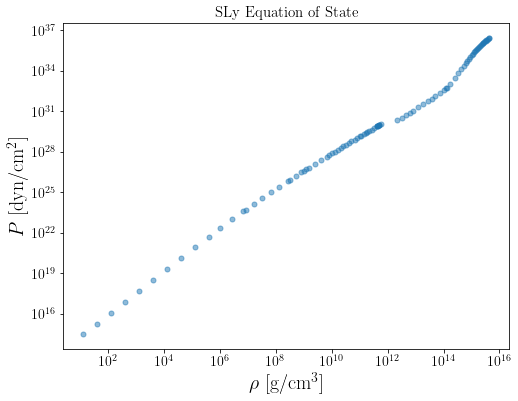

In [2]:
rhoSLy,PSLy=np.loadtxt('EOS/sly.dat',usecols=(2,1),unpack=True)
#rhoSLy = rhoSLy/rhodim
PSLy = (PSLy*c**2)

plt.loglog(rhoSLy,PSLy,"o", ms=5, alpha=0.5)
plt.xlabel(r'$\rho$ [g/cm$^3$]')
plt.ylabel(r'$P$ [dyn/cm$^2$]')
plt.title('SLy Equation of State',fontsize = 15)
plt.show()

### Using a single polytrope

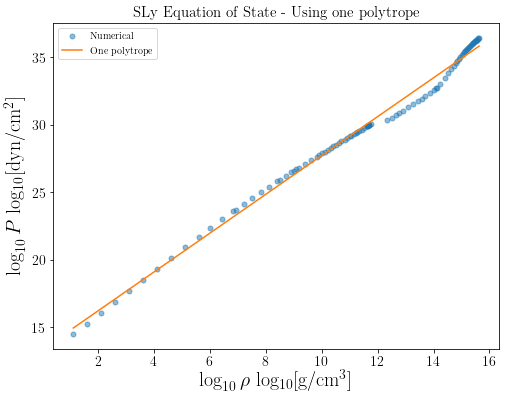

In [3]:
logrho  = np.log10(rhoSLy)
logP = np.log10(PSLy)

clf = linear_model.LinearRegression()

clf.fit(logrho[:,np.newaxis], logP)

rhogrid = np.linspace(logrho[0],logrho[-1],200)

polyP = clf.predict(rhogrid[:, np.newaxis])

plt.plot(logrho,logP,"o", ms=5, alpha=0.5,label='Numerical')
plt.plot(rhogrid,polyP,label='One polytrope')
plt.title('SLy Equation of State - Using one polytrope',fontsize = 15)
plt.xlabel(r'$\log_{10}\rho$ log$_{10}$[g/cm$^3$]')
plt.ylabel(r'$\log_{10}P$ log$_{10}$[dyn/cm$^2$]')
plt.legend()
plt.show()

How good is the fit?

In [4]:
print('Gamma',clf.coef_[0],'log10(K)',clf.intercept_ ,'RMSE',np.sqrt(mean_squared_error(logP, clf.predict(logrho[:, np.newaxis]))),'R2',r2_score(logP, clf.predict(logrho[:, np.newaxis])))

Gamma 1.4383243493886906 log10(K) 13.34350038528872 RMSE 0.45646918397661956 R2 0.9927496554374549


### Trying piecewise

In [5]:
def partialEOS(rholeft,rhoright,rhoEOS,PEOS):
            """Finds the points of the EOS inside the interval [rholeft,rhoright]"""
            partialrho_EOS = []
            partialP_EOS = []
            for k in range(len(rhoEOS)):
                if rhoEOS[k] >= rholeft and rhoEOS[k] <= rhoright:
                    #print(i)
                    partialrho_EOS.append(rhoEOS[k])
                    partialP_EOS.append(PEOS[k])
            return np.array(partialrho_EOS), np.array(partialP_EOS)

In [6]:
partialEOS(logrho[3],logrho[6],logrho,logP)

(array([2.61905594, 3.11905609, 3.6190564 , 4.11905702]),
 array([16.89406838, 17.69863712, 18.50320587, 19.30777462]))

First polytrope has $\gamma$ and $K$ as free parameters

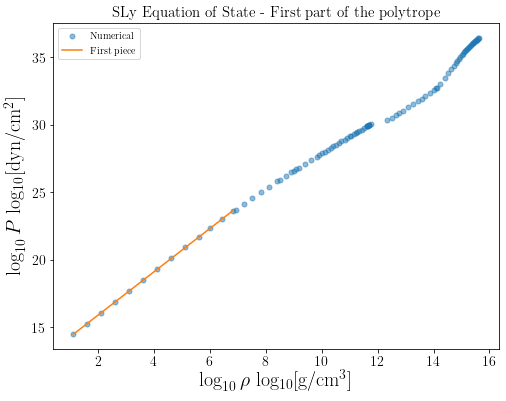

In [7]:
#choosing only some of the points of the EOS
partiallogrho1, partiallogP1 = partialEOS(logrho[0],logrho[12],logrho,logP)
reg1 = linear_model.LinearRegression()
reg1.fit(partiallogrho1[:,np.newaxis], partiallogP1)
grid1=np.linspace(logrho[0],logrho[12],50)
p1 = reg1.predict(grid1[:, np.newaxis])

plt.title('SLy Equation of State - Using one polytrope',fontsize = 15)
plt.plot(logrho,logP,"o", ms=5, alpha=0.5,label='Numerical')
plt.plot(grid1,p1,label='First piece')
plt.title('SLy Equation of State - First part of the polytrope',fontsize = 15)
plt.xlabel(r'$\log_{10}\rho$ log$_{10}$[g/cm$^3$]')
plt.ylabel(r'$\log_{10}P$ log$_{10}$[dyn/cm$^2$]')
plt.legend()
plt.show()

In [8]:
print('Gamma',reg1.coef_[0],'log10(K)',reg1.intercept_ ,'RMSE',np.sqrt(mean_squared_error(partiallogP1, reg1.predict(partiallogrho1[:, np.newaxis]))),'R2',r2_score(partiallogP1, reg1.predict(partiallogrho1[:, np.newaxis])))

Gamma 1.604149740056099 log10(K) 12.693814791017832 RMSE 0.01377785721843697 R2 0.999977389501026


All of the following polytropes will have $K$ fixed and depends on the las values of $\rho$ and $P$ as explained before

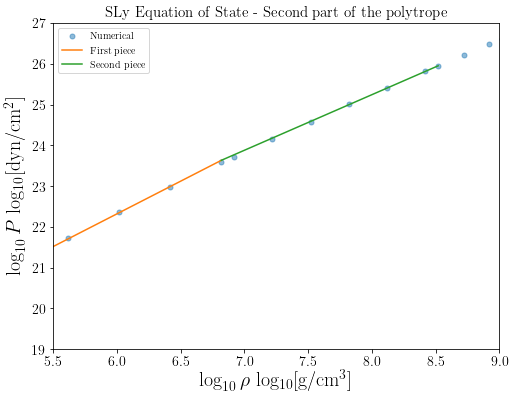

In [9]:
# former values of variables
rhof2 = logrho[12]
Pf2 = reg1.predict(np.array(rhof2).reshape(-1, 1))[0]
#choosing the next segment
partiallogrho2, partiallogP2 = partialEOS(logrho[12],logrho[19],logrho,logP)
partiallogrho2 = partiallogrho2 - rhof2
partiallogP2 = partiallogP2 - Pf2
reg2 = linear_model.LinearRegression(fit_intercept=False)
reg2.fit(partiallogrho2[:,np.newaxis], partiallogP2)
grid2=np.linspace(logrho[12]-rhof2,logrho[19]-rhof2,50)
p2 = reg2.predict(grid2[:, np.newaxis])

plt.plot(logrho,logP,"o", ms=5, alpha=0.5,label='Numerical')
plt.plot(grid1,p1,label='First piece')
plt.plot(grid2+rhof2,p2+Pf2,label='Second piece')
plt.xlim(5.5,9)
plt.ylim(19,27)
plt.title('SLy Equation of State - Second part of the polytrope',fontsize = 15)
plt.xlabel(r'$\log_{10}\rho$ log$_{10}$[g/cm$^3$]')
plt.ylabel(r'$\log_{10}P$ log$_{10}$[dyn/cm$^2$]')
plt.legend()
plt.show()

In [10]:
print('Gamma',reg2.coef_[0],'log10(K)',Pf2-reg2.coef_[0]*rhof2,'RMSE',np.sqrt(mean_squared_error(partiallogP2, reg2.predict(partiallogrho2[:, np.newaxis]))),'R2',r2_score(partiallogP2, reg2.predict(partiallogrho2[:, np.newaxis])))

Gamma 1.363858388257172 log10(K) 14.33238819058918 RMSE 0.024332575084440634 R2 0.9991907046227252


In [15]:
partiallogrho2+rhof2

array([6.819111  , 6.91908294, 7.21904622, 7.51916171, 7.81928967,
       8.11928273, 8.41933892, 8.51935721])

### Using the RMSE to choose the divisions

According to some papers a good $RMSE=0.04$. So using a $RMSE=0.04$ as the limit where a fit is acceptable, the whole range of densities can be fitted with one polytrope in ranges that increase in small steps $\Delta{\rho}$ until the fit has a $RMSE>0.04$, where a new density range will be fitted with a different polytrope and so forth. 

In [50]:
#defining the step
n = 20 #number of subdivisions
deltarho = (logrho[-1] - logrho[0])/n
rhointerval=[]
rhointerval.append(logrho[0])
rhointervalf=[]
rhointervalf.append(logrho[0])
coeffs = []
RMSE = 0
i=0
j=0
while rhointerval[i] <= logrho[-2]: 
    while RMSE < 0.005:
        rhointerval.append(rhointerval[i]+deltarho)
        if rhointervalf[j] == logrho[0]: # in the first polytrope both gamma and K are free
            partiallogrho, partiallogP = partialEOS(rhointervalf[j],rhointerval[i+1],logrho,logP)
            reg = linear_model.LinearRegression()
            reg.fit(partiallogrho[:,np.newaxis], partiallogP)
            RMSE = np.sqrt(mean_squared_error(partiallogP, reg.predict(partiallogrho[:, np.newaxis])))
            # saving limit values of logrho and logP
            rhof = rhointerval[i+1]
            Pf = reg.predict(np.array(rhof).reshape(-1, 1))[0]
            i += 1
            #print('here1')
        else: # starting from the second polytrope, continuity of the pressure fixes K
            #print('here2')
            partiallogrho, partiallogP = partialEOS(rhointervalf[j],rhointerval[i+1],logrho,logP)
            partiallogrho = partiallogrho - rhof
            partiallogP = partiallogP - Pf
            reg = linear_model.LinearRegression(fit_intercept=False)
            reg.fit(partiallogrho[:,np.newaxis], partiallogP)
            RMSE = np.sqrt(mean_squared_error(partiallogP, reg.predict(partiallogrho[:, np.newaxis])))
            Pf = reg.predict(np.array(rhointerval[i+1]-rhof).reshape(-1, 1))[0]+Pf
            rhof = rhointerval[i+1] + rhof
            i += 1
            #print('here2')
    #print(RMSE)
    rhointervalf.append(rhointerval[i])
    RMSE = 0
    if rhointervalf[j] == logrho[0]:
        coeffs.append([reg.coef_[0],reg.intercept_])
    else:
        coeffs.append([reg.coef_[0],Pf-reg.coef_[0]*rhof])
    j += 1

In [18]:
tol = 0.04
RMSE = 0
rho_0 = logrho[0]
intervalst = []
#intervalst.append(rho_0)
intervals = [] #array wich will save the density intervals
#intervals.append(rho_0)
coeffst= []
coeffs = []
n=0
success = True
for density in logrho[1:]: #excluding the first item
    while success == True:
        if rho_0 == logrho[0]: #Regression for the frist polytrope
            plogrho, plogP = partialEOS(rho_0,density,logrho,logP) #partial EOSs
            reg = linear_model.LinearRegression()
            reg.fit(plogrho[:,np.newaxis], plogP)
            RMSE = np.sqrt(mean_squared_error(plogP, reg.predict(plogrho[:, np.newaxis])))
            # values of parameters
            gamma = reg1.coef_[0]
            logK = reg1.intercept_
            coeffst.append([gamma,logK])
            # saving limit values of logrho and logP
            Pf = reg.predict(np.array(density).reshape(-1, 1))[0]
            rhof = density
            intervalst.append([rhof,Pf])
            print(plogrho,'FP')
            print('Error',RMSE)
        else: # polytrope where K is fixed
            plogrho, plogP = partialEOS(rho_0,density,logrho,logP)
            print(plogrho)
            plogrho = plogrho - rho_0 
            plogP = plogP - P_0
            #print(plogrho)
            #print(plogP)
            reg = linear_model.LinearRegression(fit_intercept=False)
            reg.fit(plogrho[:,np.newaxis], plogP)
            RMSE = np.sqrt(mean_squared_error(plogP, reg.predict(plogrho[:, np.newaxis])))
            # values of parameters
            gamma = reg.coef_[0]
            logK = Pf-reg.coef_[0]*rhof
            coeffst.append([gamma,logK])
            # saving limit values of logrho and logP
            Pf = reg.predict(np.array(density-rhof).reshape(-1, 1))[0]+Pf
            rhof = density
            intervalst.append([rhof,Pf])
            print('Error',RMSE)
        if RMSE < tol:
            success = False
            #print('Here3')
        else:
            rhof, Pf = intervalst[-2]
            rho_0 = rhof
            P_0 = Pf
            intervals.append([rhof,Pf])
            coeffs.append(coeffst[-2])
            print('New initial density',rho_0)
            print('Current density',density)
            n += 1
            if n == 1:
                tol += 0.02
    success = True

[1.11905581 1.61905583] FP
Error 1.7763568394002505e-15
[1.11905581 1.61905583 2.11905587] FP
Error 7.1414864156634544e-09
[1.11905581 1.61905583 2.11905587 2.61905594] FP
Error 2.310595685586348e-08
[1.11905581 1.61905583 2.11905587 2.61905594 3.11905609] FP
Error 6.007376068828541e-08
[1.11905581 1.61905583 2.11905587 2.61905594 3.11905609 3.6190564 ] FP
Error 1.4157657859628997e-07
[1.11905581 1.61905583 2.11905587 2.61905594 3.11905609 3.6190564
 4.11905702] FP
Error 3.158613167324676e-07
[1.11905581 1.61905583 2.11905587 2.61905594 3.11905609 3.6190564
 4.11905702 4.61905826] FP
Error 6.81259099256885e-07
[1.11905581 1.61905583 2.11905587 2.61905594 3.11905609 3.6190564
 4.11905702 4.61905826 5.11906077] FP
Error 1.4371814059699512e-06
[1.11905581 1.61905583 2.11905587 2.61905594 3.11905609 3.6190564
 4.11905702 4.61905826 5.11906077 5.61906583] FP
Error 2.9865015314792807e-06
[1.11905581 1.61905583 2.11905587 2.61905594 3.11905609 3.6190564
 4.11905702 4.61905826 5.11906077 5.619

In [19]:
coeffs

[[1.604149740056099, 12.693814791017832],
 [1.2914452403102186, 14.917277558255746],
 [0.5182134706218905, 23.946157435791534],
 [0.601787328414533, 22.901290650373994],
 [1.9830020381688087, 5.632907786762484],
 [1.3716483462787699, 13.308845808473375],
 [1.4088595235486165, 12.779362935849953],
 [3.6480606775910758, -19.082533043045395],
 [2.7145552103984336, -5.49922992648235],
 [2.700174661608994, -5.278264878737545],
 [-6.292953764567329, 132.90610354568037]]

In [20]:
intervals

[[7.219046220004181, 24.237986515456463],
 [11.757456503185473, 30.10138879744905],
 [12.502316071252695, 30.425026037887232],
 [12.651893065428407, 30.51503957760451],
 [12.651893065428407, 30.721637522200833],
 [14.229135208051606, 32.82621558557438],
 [14.406871831957895, 33.076621520848136],
 [14.406871831957895, 33.47460957421471],
 [15.365550437621275, 36.21140507460241],
 [15.395064499243311, 36.2910981959554],
 [15.395064499243311, 36.025674449410346]]

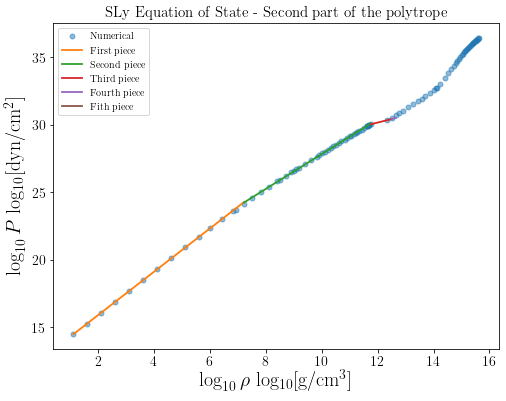

In [37]:
def logpoly(logrho,coeffss):
    return coeffss[0]*logrho+coeffss[1]
    
interval1 = np.linspace(logrho[0],intervals[0][0],50)
interval2 = np.linspace(intervals[0][0],intervals[1][0],50)
interval3 = np.linspace(intervals[1][0],intervals[2][0],50)
interval4 = np.linspace(intervals[2][0],intervals[3][0],50)
interval5 = np.linspace(intervals[3][0],intervals[4][0],50)

plt.plot(logrho,logP,"o", ms=5, alpha=0.5,label='Numerical')
plt.plot(interval1,logpoly(interval1,coeffs[0]),label='First piece',lw = 1.8)
plt.plot(interval2,logpoly(interval2,coeffs[1]),label='Second piece',lw = 1.8)
plt.plot(interval3,logpoly(interval3,coeffs[2]),label='Third piece',lw = 1.8)
plt.plot(interval4,logpoly(interval4,coeffs[3]),label='Fourth piece',lw = 1.8)
plt.plot(interval5,logpoly(interval5,coeffs[4]),label='Fith piece',lw = 1.8)

plt.title('SLy Equation of State - Second part of the polytrope',fontsize = 15)
plt.xlabel(r'$\log_{10}\rho$ log$_{10}$[g/cm$^3$]')
plt.ylabel(r'$\log_{10}P$ log$_{10}$[dyn/cm$^2$]')
plt.legend()
plt.show()
